# Predicting Mortgage Approvals From Government Data

Housing markets place disproportionate financial stress on low-income households, who tend to face similar housing costs as middle-income Americans, despite lower paychecks. Housing issues are intertwined with many other social problems, including poverty, educational disparities, and health care. Digging into underlying patterns in housing costs can be an important first step toward greater visibility and better policies.

Now, we are challenging you **to consider how poverty, income, health, ethnicity, and other sociodemographic factors are related to rent costs**, and to use your skills to build a model for predicting median gross rent values in counties across the United States.
Our goal in this notebook is execute an Exploratory Data Analysis for a data scientist beginners, so in a few steps we can extract some valuable information from the data set.


## Loading and describing the data

Importing some basic libraries and loading the train and test datasets.
Our first step is a brief exploration on the dataset provided, we want to get some rapid insights or ideas about our dataset. So first of all, we list all columns, datatypes, number of rows,

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import math
import scipy

%matplotlib inline

In [4]:
train_data = pd.read_csv('train_values.csv', sep=',', header=0,index_col=0)
train_label = pd.read_csv('train_labels.csv', sep=',', header=0,index_col=0)

test_data = pd.read_csv('test_values.csv', sep=',', header=0,index_col=0)

lender_data = pd.read_csv('Lender_level.csv', sep=',', header=0,index_col=0)

In [5]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 500000 entries, 0 to 499999
Data columns (total 21 columns):
loan_type                         500000 non-null int64
property_type                     500000 non-null int64
loan_purpose                      500000 non-null int64
occupancy                         500000 non-null int64
loan_amount                       500000 non-null float64
preapproval                       500000 non-null int64
msa_md                            500000 non-null int64
state_code                        500000 non-null int64
county_code                       500000 non-null int64
applicant_ethnicity               500000 non-null int64
applicant_race                    500000 non-null int64
applicant_sex                     500000 non-null int64
applicant_income                  460052 non-null float64
population                        477535 non-null float64
minority_population_pct           477534 non-null float64
ffiecmedian_family_income         477560 

So, we have **500,000 data records, grouped in 23 data columns, most of them numerical, some columns have missing values and one variable is boolean**. Comparing the data with the problem description, we actually can define two groups of variables:
- Categorical (numerical but not a "number" or quantitative value): loan_type, property_type, occupancy, pre-approval, msa_md, state_code,county_code, applicant_ethnicity, applicant_race, applicant_sex, lender, co_applicant
- Numerical: loan_amount, population, minority_population_pct, ffiecmedian_family_income, number_of_owner-occupied_units, number_of_1_to_4_family_units,…
- Label: accepted, this is our targeted variable


In [6]:
# Define some interesting groups of columns by datatype
var_numeric = ['loan_amount','applicant_income','population','ffiecmedian_family_income',
                 'number_of_owner-occupied_units','number_of_1_to_4_family_units']

var_numeric_pct = ['minority_population_pct','tract_to_msa_md_income_pct']

var_categoric = ['loan_type','property_type','loan_purpose','occupancy','preapproval','state_code','county_code','msa_md',
                  'applicant_ethnicity','applicant_race','applicant_sex','lender']
# msa/md, state code and county code are categorical not ordinal, all of them related

var_logic = ['co_applicant']
# Inlude labels in training data
train_data['accepted'] = train_label.values
#Delete rows withs any nan values 
train_data_nona = train_data[var_numeric+var_numeric_pct+['accepted']].dropna(axis=0)


## Initial data exploration
Lets apply pandas describe function to extract basic statistics from categorical and numerical variables 

In [7]:
# For categorical data
train_data[var_categoric].describe()

,loan_type,property_type,loan_purpose,occupancy,preapproval,state_code,county_code,msa_md,applicant_ethnicity,applicant_race,applicant_sex,lender
count,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000
mean,1.366276,1.047650,2.066810,1.109590,2.764722,23.726924,144.542062,181.606972,2.036228,4.786586,1.462374,3720.121344
std,0.690555,0.231404,0.948371,0.326092,0.543061,15.982768,100.243612,138.464169,0.511351,1.024927,0.677685,1838.313175
min,1.000000,1.000000,1.000000,1.000000,1.000000,-1.000000,-1.000000,-1.000000,1.000000,1.000000,1.000000,0.000000
25%,1.000000,1.000000,1.000000,1.000000,3.000000,6.000000,57.000000,25.000000,2.000000,5.000000,1.000000,2442.000000
50%,1.000000,1.000000,2.000000,1.000000,3.000000,26.000000,131.000000,192.000000,2.000000,5.000000,1.000000,3731.000000
75%,2.000000,1.000000,3.000000,1.000000,3.000000,37.000000,246.000000,314.000000,2.000000,5.000000,2.000000,5436.000000
max,4.000000,3.000000,3.000000,3.000000,3.000000,52.000000,324.000000,408.000000,4.000000,7.000000,4.000000,6508.000000


In [8]:
# For numerical variables
train_data[var_numeric].describe()

,loan_amount,applicant_income,population,ffiecmedian_family_income,number_of_owner-occupied_units,number_of_1_to_4_family_units
count,500000.000000,460052.000000,477535.000000,477560.000000,477435.000000,477470.000000
mean,221.753158,102.389521,5416.833956,69235.603298,1427.718282,1886.147065
std,590.641648,153.534496,2728.144999,14810.058791,737.559511,914.123744
min,1.000000,1.000000,14.000000,17858.000000,4.000000,1.000000
25%,93.000000,47.000000,3744.000000,59731.000000,944.000000,1301.000000
50%,162.000000,74.000000,4975.000000,67526.000000,1327.000000,1753.000000
75%,266.000000,117.000000,6467.000000,75351.000000,1780.000000,2309.000000
max,100878.000000,10139.000000,37097.000000,125248.000000,8771.000000,13623.000000


This brief data analysis give us some useful information:
- Many categorical variables take the same value for almost every row: propery_type, occupancy and preapproval.
- Approval value "It not applicable" for almost every row.
- Applicant race, ethnicity and sex have mainly two values, we will dive deeper later.
- There are missing values in location variable, and this variable should be an important variable.
- Presence of a lot of outliers (or data errors) in most of the numerical features. Especially loan amount and applicant income. Loan_amount mean is about 200 but maximum value is higher than 100,000 and standard deviation is almost 600. It looks like there are some wrongs values in the data.
- In general, the dataset seems to be balanced between accepted and not accepted applications

## Exploring categorical variables

First, a basic boxplots to identify how values are spread along its range:

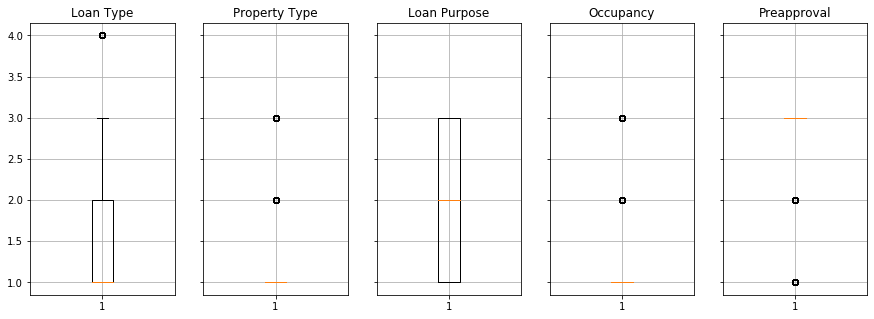

In [9]:
f, axes = plt.subplots(1, 5, sharey=True, figsize=(15,5))

axes[0].set_title('Loan Type')
axes[1].set_title('Property Type')
axes[2].set_title('Loan Purpose')
axes[3].set_title('Occupancy')
axes[4].set_title('Preapproval')

for i in axes:
    i.grid(True)
axes[0].boxplot(train_data['loan_type'])
axes[1].boxplot(train_data['property_type'])
axes[2].boxplot(train_data['loan_purpose'])
axes[3].boxplot(train_data['occupancy'])
axes[4].boxplot(train_data['preapproval'])

plt.show()

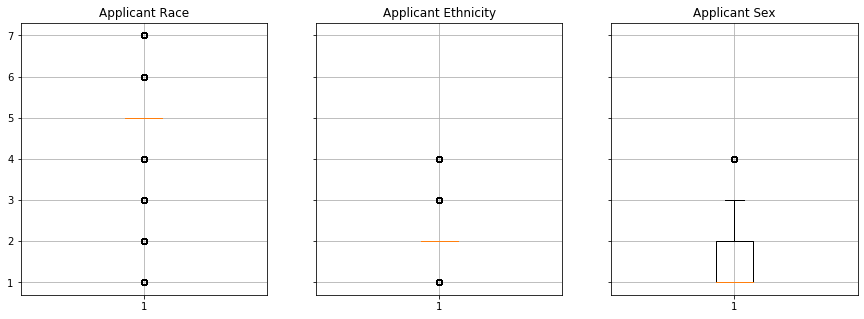

In [10]:
f, axes = plt.subplots(1, 3, sharey=True, figsize=(15,5))
#fig1, ax1 = plt.subplots()
axes[0].set_title('Applicant Race')
axes[1].set_title('Applicant Ethnicity')
axes[2].set_title('Applicant Sex')
#ax0.set_ylabel('Count')
for i in axes:
    i.grid(True)
axes[0].boxplot(train_data['applicant_race'])
axes[1].boxplot(train_data['applicant_ethnicity'])
axes[2].boxplot(train_data['applicant_sex'])

plt.show()

### Histograms of categorical variables

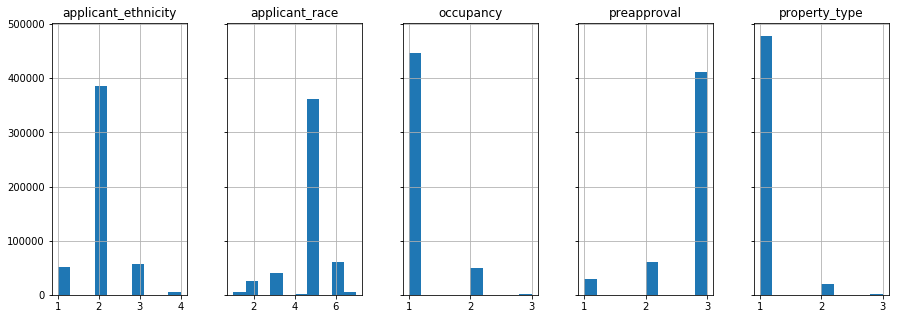

In [11]:
train_data[['property_type','occupancy','preapproval','applicant_ethnicity','applicant_race']].hist(figsize=(15,5),
                                                                                                    layout=(1,5),sharey=True)
plt.show()

We use boxplot to see how values are spread along the range, many of the figures shows that most of the rows has a unique value and we should explore if the label variable distribution is affected by some of these features. Let´s plot some richer graphics than the previous ones:

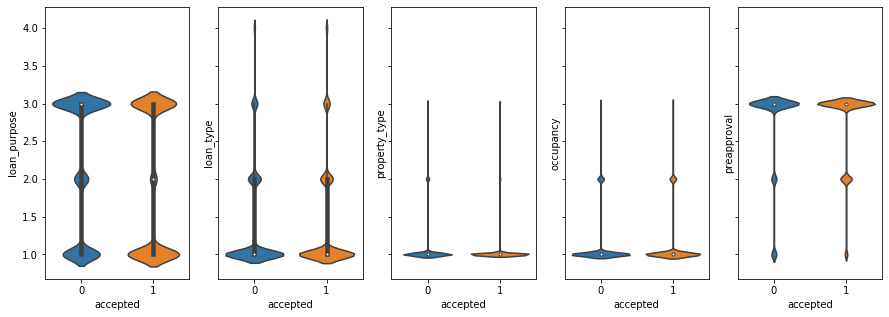

In [16]:
# Plotting violin boxplots for the categorical data
data_cat=train_data[var_categoric+['accepted']]

n_plots=5
f, axes = plt.subplots(1, 5, sharey=True, figsize=(15,5))
sns.catplot(x="accepted", y="loan_purpose", kind="violin", data=data_cat, ax=axes[0])
#plt.subplot(1,5,2)
sns.catplot(x="accepted", y="loan_type", kind="violin", data=data_cat, ax=axes[1])
#plt.subplot(1,5,3)
sns.catplot(x="accepted", y="property_type", kind="violin", data=data_cat, ax=axes[2])
#plt.subplot(1,5,4)
sns.catplot(x="accepted", y="occupancy", kind="violin", data=data_cat, ax=axes[3])
#plt.subplot(1,5,5)
sns.catplot(x="accepted", y="preapproval", kind="violin", data=data_cat, ax=axes[4])

for i in range(2,2+n_plots):
    plt.close(i)
    
plt.show()

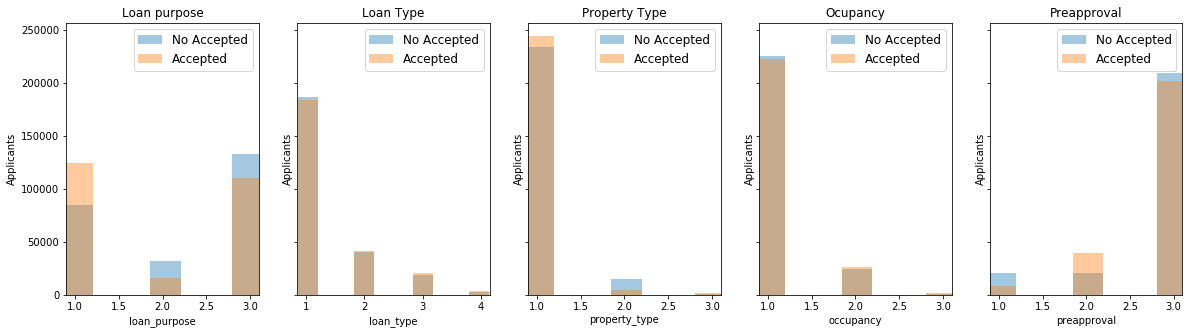

In [18]:
# Plotting histograms for the categorical data in the previous boxplots
data_cat=train_data[var_categoric+['accepted']]

def change_width(ax, new_value) :
    for patch in ax.patches :
        current_width = patch.get_width()
        diff = current_width - new_value

        # we change the bar width
        patch.set_width(new_value)

        # we recenter the bar
        patch.set_x(patch.get_x() + diff * .5)

f, axes = plt.subplots(1, 5, sharey=True, figsize=(20,5))

df0 = data_cat[data_cat.accepted == 0]
df1 =data_cat[data_cat.accepted == 1]

sns.distplot(df0['loan_purpose'],  kde=False, label='No Accepted',ax=axes[0])
sns.distplot(df1['loan_purpose'],  kde=False,label='Accepted',ax=axes[0])
axes[0].legend(prop={'size': 12})
axes[0].set_title('Loan purpose')
#axes[0,0].set_xlabel('Loan purpose')
axes[0].set_ylabel('Applicants')
change_width(axes[0], .35)

sns.distplot(df0['loan_type'],  kde=False, label='No Accepted',ax=axes[1])
sns.distplot(df1['loan_type'],  kde=False,label='Accepted',ax=axes[1])
axes[1].legend(prop={'size': 12})
axes[1].set_title('Loan Type')
#axes[0,1].set_xlabel('Loan Type')
axes[1].set_ylabel('Applicants')
change_width(axes[1], .35)

sns.distplot(df0['property_type'],  kde=False, label='No Accepted',ax=axes[2])
sns.distplot(df1['property_type'],  kde=False,label='Accepted',ax=axes[2])
axes[2].legend(prop={'size': 12})
axes[2].set_title('Property Type')
#axes[1,0].set_xlabel('Property Type')
axes[2].set_ylabel('Applicants')
change_width(axes[2], .35)

sns.distplot(df0['occupancy'],  kde=False, label='No Accepted',ax=axes[3])
sns.distplot(df1['occupancy'],  kde=False,label='Accepted',ax=axes[3])
axes[3].legend(prop={'size': 12})
axes[3].set_title('Ocupancy')
#axes[1,1].set_xlabel('Ocuppancy')
axes[3].set_ylabel('Applicants')
change_width(axes[3], .35)

sns.distplot(df0['preapproval'],  kde=False, label='No Accepted',ax=axes[4])
sns.distplot(df1['preapproval'],  kde=False,label='Accepted',ax=axes[4])
axes[4].legend(prop={'size': 12})
axes[4].set_title('Preapproval')
#axes[1,1].set_xlabel('Ocuppancy')
axes[4].set_ylabel('Applicants')
change_width(axes[4], .35)

plt.show()

- We can see that loans for home purchasing (loan purpose = 1) are most likely to be accepted than loans for home refinancing (loan purpose = 3).
- The loan acceptance is not affected by the loan type or the property type. No matter if it is a conventional loan or government-guaranteed, they all have same opportunities. But most of applications are conventional loans (loan type = 1) and One to four -family properties (property type = 1)
- Owner´s principal dwelling (occupancy = 1) are the most frequent applications

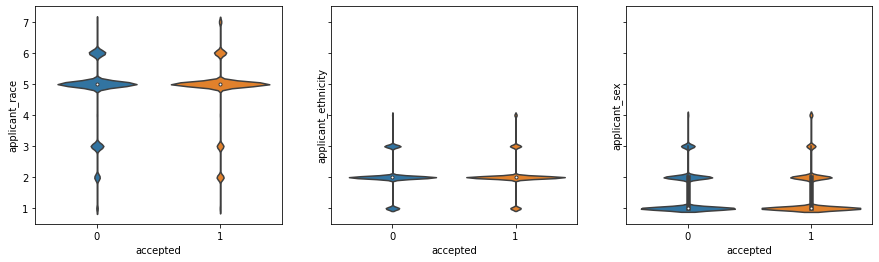

In [19]:
# Plotting violin boxplots for the categorical data
data_cat=train_data[var_categoric+['accepted']]

n_plots=3

f, axes = plt.subplots(1, 3, sharey=True, figsize=(15,4))
sns.catplot(x="accepted", y="applicant_race", kind="violin", data=data_cat, ax=axes[0])
#plt.subplot(1,5,2)
sns.catplot(x="accepted", y="applicant_ethnicity", kind="violin", data=data_cat, ax=axes[1])
#plt.subplot(1,5,3)
sns.catplot(x="accepted", y="applicant_sex", kind="violin", data=data_cat, ax=axes[2])

for i in range(2,2+n_plots):
    plt.close(i)
    
plt.show()

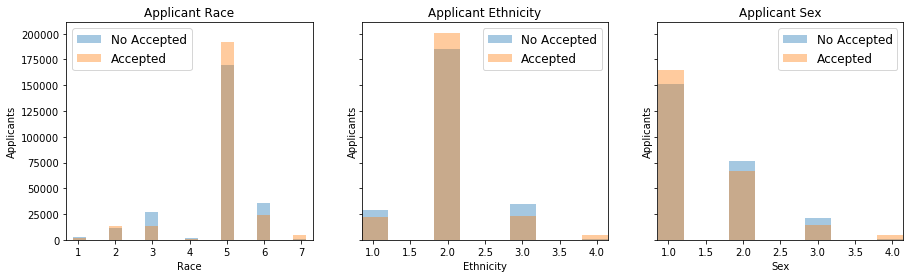

In [20]:
# Plotting simple boxplots for the categorical data
data_cat=train_data[var_categoric+['accepted']]

def change_width(ax, new_value) :
    for patch in ax.patches :
        current_width = patch.get_width()
        diff = current_width - new_value

        # we change the bar width
        patch.set_width(new_value)

        # we recenter the bar
        patch.set_x(patch.get_x() + diff * .5)

f, axes = plt.subplots(1,3, sharey=True, figsize=(15,4))

df0 = data_cat[data_cat.accepted == 0]
df1 =data_cat[data_cat.accepted == 1]

sns.distplot(df0['applicant_race'],  kde=False, label='No Accepted',ax=axes[0])
sns.distplot(df1['applicant_race'],  kde=False,label='Accepted',ax=axes[0])
axes[0].legend(prop={'size': 12})
axes[0].set_title('Applicant Race')
axes[0].set_xlabel('Race')
axes[0].set_ylabel('Applicants')
change_width(axes[0], .35)

sns.distplot(df0['applicant_ethnicity'],  kde=False, label='No Accepted',ax=axes[1])
sns.distplot(df1['applicant_ethnicity'],  kde=False,label='Accepted',ax=axes[1])
axes[1].legend(prop={'size': 12})
axes[1].set_title('Applicant Ethnicity')
axes[1].set_xlabel('Ethnicity')
axes[1].set_ylabel('Applicants')
change_width(axes[1], .35)

sns.distplot(df0['applicant_sex'],  kde=False, label='No Accepted',ax=axes[2])
sns.distplot(df1['applicant_sex'],  kde=False,label='Accepted',ax=axes[2])
axes[2].legend(prop={'size': 12})
axes[2].set_title('Applicant Sex')
axes[2].set_xlabel('Sex')
axes[2].set_ylabel('Applicants')
change_width(axes[2], .35)

plt.show()

- Most of the applicants are white (5), not latino (2) and male (1) people and its ratio of acceptance is positive
- However, the requests of black (3), hispanic people (1) or women (2) are slightly rejected. But the difference is too small that we cannot confirm it as a discriminant factor
- We appreciate that applicants who do not provide that kind of information tends to be not-accepted, so this information seems to be relevant for the lender.

**Lender** variable is an especial feature with a lot of different values as shown in the next figure:

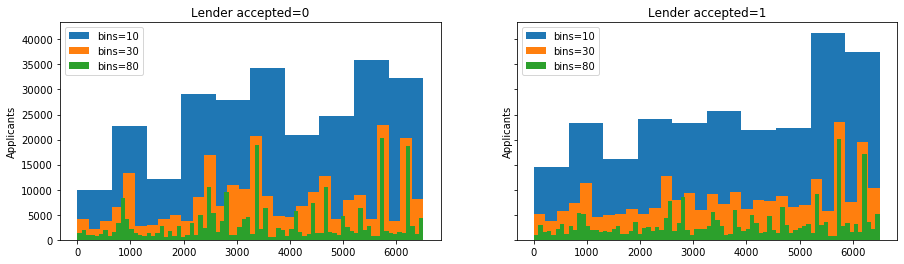

In [21]:
#lender_data.hist()
df0 = data_cat[data_cat.accepted == 0]
df1 =data_cat[data_cat.accepted == 1]

f, axes = plt.subplots(1,2, sharey=True, figsize=(15,4))

axes[0].hist(df0['lender'],bins=10, label='bins=10')
axes[0].hist(df0['lender'],bins=30, label='bins=30')
axes[0].hist(df0['lender'],bins=80, label='bins=80')
axes[0].set_title('Lender accepted=0')
axes[0].set_ylabel('Applicants')
axes[0].legend()

axes[1].hist(df1['lender'],bins=10, label='bins=10')
axes[1].hist(df1['lender'],bins=30, label='bins=30')
axes[1].hist(df1['lender'],bins=80, label='bins=80')
axes[1].set_title('Lender accepted=1')
axes[1].set_ylabel('Applicants')
axes[1].legend()
plt.show()

When we define only 10 bins, some kind of linear increasing tendency is shown. But when number of bins is increased, the tendency is flatten, as it is supposed, but some peaks are revealed. We need to transform this data in order to get any sort of information. We consider the ratio of acceptance of a lender as a good piece of information, so for every lender, its acceptance ratio is calculated and we also need to reduce the number of categories: 6.1 thousand is not acceptable for a categorical variable. Then we decided to define levels of acceptance ratio: level 0 for 0%, level 1 for 0–12,5% ratio acceptance, level 2 for 12,5%-25% and so on.

We will create a dataframe with the lender levels and its ratio of acceptance:

In [88]:

column='lender'
label='accepted'

data=train_data.copy()

ratios = np.array([sum(data[data[column]==i][label])/len(data[data[column]==i]) for i in data[column].unique()])
levels = np.floor(ratios/0.125)

lender_data = pd.DataFrame(index=data[column].unique(),data=np.concatenate((np.reshape(ratios,(len(ratios),-1)),np.reshape(levels,(len(levels),-1))),axis=1),
             columns=['ratio','level'])

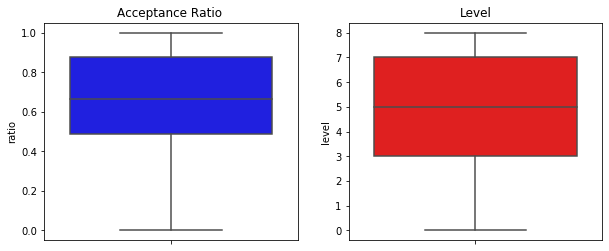

In [91]:
# Plotting simple boxplots for the categorical data
f, axes = plt.subplots(1, 2, figsize=(10,4))

n_plots=2
sns.catplot(y="ratio", kind="box", data=lender_data, color='b', ax=axes[0]) #, ax=axes[0])
axes[0].set_title('Acceptance Ratio ')
#axes[0,0].set_xlabel('Loan purpose')
sns.catplot(y="level", kind="box", data=lender_data, color='r', ax=axes[1])
axes[1].set_title('Level')

for i in range(2,2+n_plots):
    plt.close(i)
    
plt.show()


The acceptance ratio for most of the lender is between 0.5 and 0.9, median 0.7 approx. So there is some positive tendency in accepting loans.
Now, we need to explore the distribution of the lender levels based on target labels

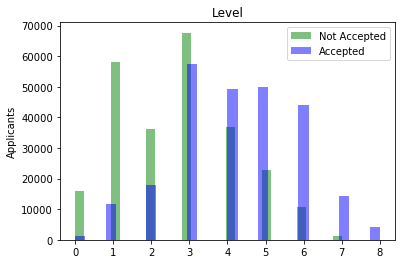

In [92]:
# 
df= train_data.join(lender_data, on='lender')

df0 = df[df.accepted == 0]
df1 = df[df.accepted == 1]

plt.hist(df0['level'],bins=30, label='Not Accepted', color='g', alpha=0.5)
plt.hist(df1['level'],bins=30, label='Accepted', color='b', alpha=0.5)
plt.title('Level')
plt.ylabel('Applicants')
plt.legend()

plt.show()

## Location features
Lets plot boxplots on location variables State, County and MSA MD 

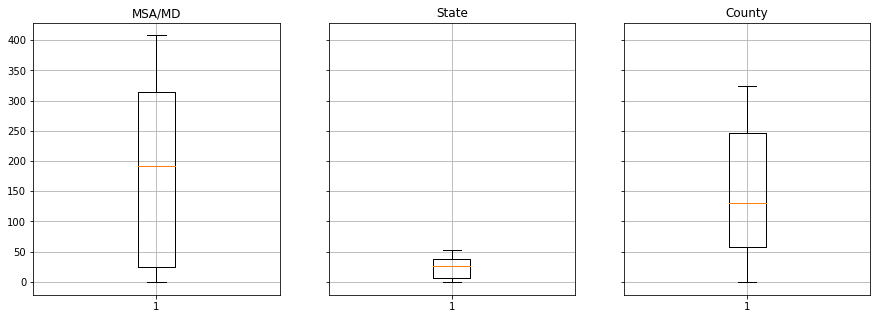

In [93]:
# Boxplots for State, Count and MSD/DA data
f, axes = plt.subplots(1, 3, sharey=True, figsize=(15,5))
#fig1, ax1 = plt.subplots()
axes[0].set_title('MSA/MD')
axes[1].set_title('State')
axes[2].set_title('County')

for i in axes:
    i.grid(True)
axes[0].boxplot(train_data['msa_md'])
axes[1].boxplot(train_data['state_code'])
axes[2].boxplot(train_data['county_code'])

plt.show()

Lets plot some histograms on location variables State, County and MSA MD:

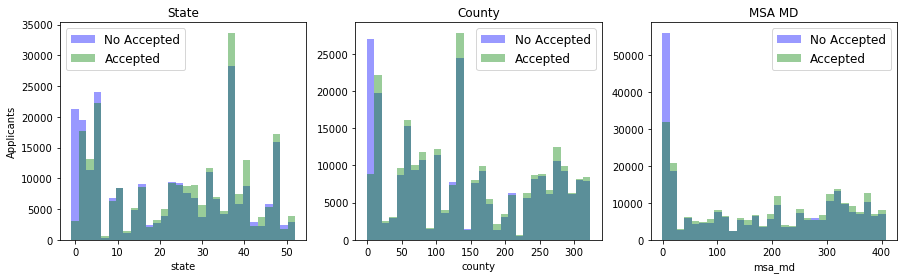

In [94]:
# Plotting simple boxplots for the categorical data
data_cat=train_data[var_categoric+['accepted']]

def change_width(ax, new_value) :
    for patch in ax.patches :
        current_width = patch.get_width()
        diff = current_width - new_value

        # we change the bar width
        patch.set_width(new_value)

        # we recenter the bar
        patch.set_x(patch.get_x() + diff * .5)

f, axes = plt.subplots(1,3, figsize=(15,4))

df0 = data_cat[data_cat.accepted == 0]
df1 =data_cat[data_cat.accepted == 1]

sns.distplot(df0['state_code'],  kde=False, label='No Accepted', bins=30, color='b', ax=axes[0])
sns.distplot(df1['state_code'],  kde=False,label='Accepted',bins=30, color='g', ax=axes[0])
axes[0].legend(prop={'size': 12})
axes[0].set_title('State')
axes[0].set_xlabel('state')
axes[0].set_ylabel('Applicants')

sns.distplot(df0['county_code'],  kde=False, label='No Accepted',bins=30, color='b', ax=axes[1])
sns.distplot(df1['county_code'],  kde=False,label='Accepted',bins=30, color='g', ax=axes[1])
axes[1].legend(prop={'size': 12})
axes[1].set_title('County')
axes[1].set_xlabel('county')

sns.distplot(df0['msa_md'],  kde=False, label='No Accepted',bins=30, color='b', ax=axes[2])
sns.distplot(df1['msa_md'],  kde=False,label='Accepted',bins=30,color='g', ax=axes[2])
axes[2].legend(prop={'size': 12})
axes[2].set_title('MSA MD')
axes[2].set_xlabel('msa_md')

plt.show()

- There are a lot of records with a missing value (-1) in these columns and many of them are not accepted.
- Records with all of them as missing values (-1 in every column): there are many missing values in these rows, probably can not infer so much about them.

## Exploring numerical variables

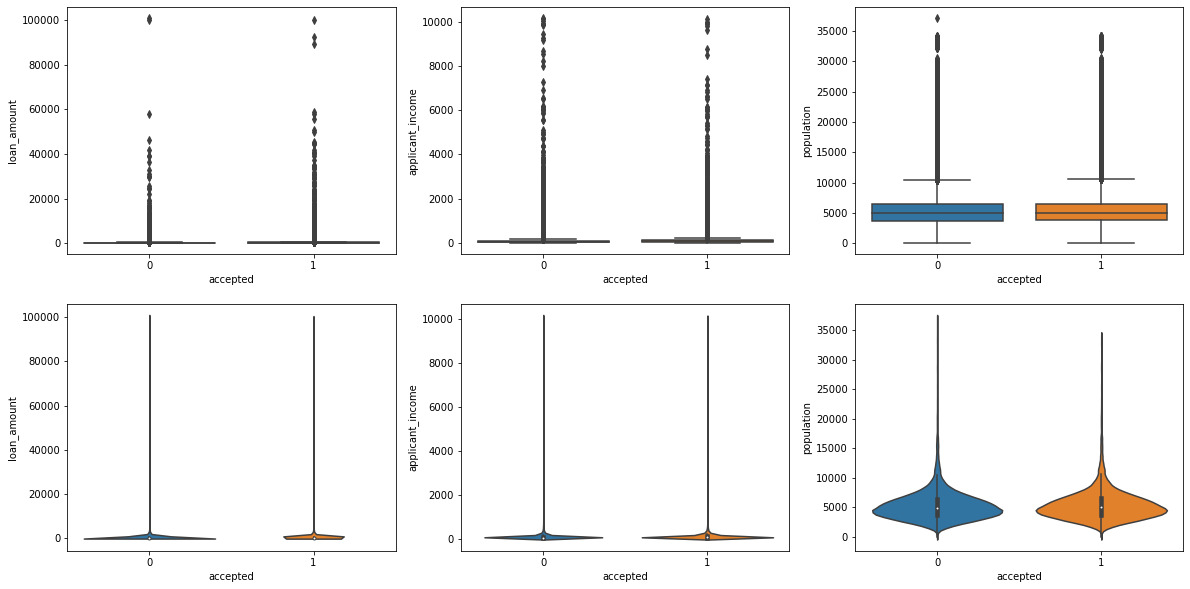

In [95]:
# Plotting some boxplots for the numerical variables
data_cat=train_data[var_numeric+var_numeric_pct+['accepted']]

n_plots=6

f, axes = plt.subplots(2, 3, sharey=False, figsize=(20,10))
sns.catplot(x="accepted", y="loan_amount", kind="box", data=data_cat, ax=axes[0,0])
sns.catplot(x="accepted", y="applicant_income", kind="box", data=data_cat, ax=axes[0,1])
sns.catplot(x="accepted", y="population", kind="box", data=data_cat, ax=axes[0,2])

sns.catplot(x="accepted", y="loan_amount", kind="violin", data=data_cat, ax=axes[1,0])
sns.catplot(x="accepted", y="applicant_income", kind="violin", data=data_cat, ax=axes[1,1])
sns.catplot(x="accepted", y="population", kind="violin", data=data_cat, ax=axes[1,2])

for i in range(2,2+n_plots):
    plt.close(i)
    
plt.show()

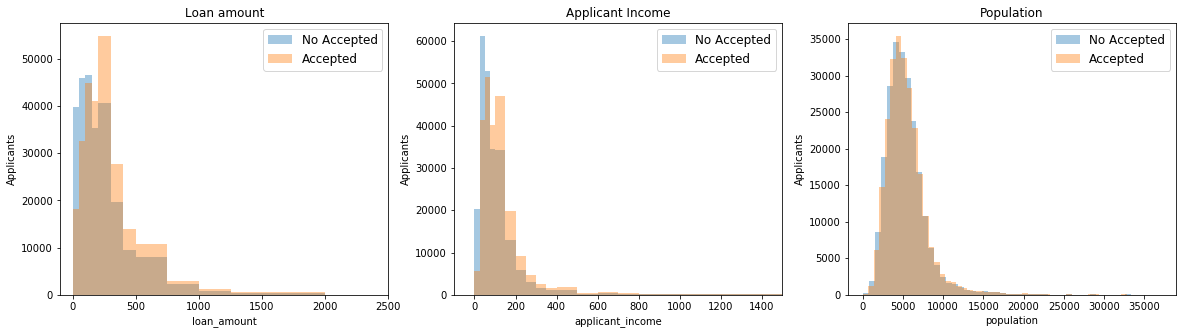

In [96]:
# Plotting some histograms for the numerical variables
f, axes = plt.subplots(1, 3, figsize=(20,5))

data_cat=train_data[train_data['loan_amount'].notnull()][['loan_amount','accepted']]
df0 = data_cat[data_cat.accepted == 0]
df1 =data_cat[data_cat.accepted == 1]


sns.distplot(df0['loan_amount'],  kde=False, label='No Accepted',bins=[0,50,100,150,200,300,400,500,750,1000,1250,1500,2000], ax=axes[0])
sns.distplot(df1['loan_amount'],  kde=False,label='Accepted',bins=[0,50,100,150,200,300,400,500,750,1000,1250,1500,2000], ax=axes[0])
axes[0].legend(prop={'size': 12})
axes[0].set_title('Loan amount')
axes[0].set_xlim(right=2500)
axes[0].set_ylabel('Applicants')


data_cat=train_data[train_data['applicant_income'].notnull()][['applicant_income','accepted']]
df0 = data_cat[data_cat.accepted == 0]
df1 =data_cat[data_cat.accepted == 1]

sns.distplot(df0['applicant_income'],  kde=False, label='No Accepted', bins=[0,25,50,75,100,150,200,250,300,350,400,500,550,600,700,800,900,1000,1250,1500,1750,2000], ax=axes[1])
sns.distplot(df1['applicant_income'],  kde=False,label='Accepted', bins=[0,25,50,75,100,150,200,250,300,350,400,500,550,600,700,800,900,1000,1250,1500,1750,2000], ax=axes[1])
axes[1].legend(prop={'size': 12})
axes[1].set_title('Applicant Income')
axes[1].set_xlim(right=1500)
#axes[0,1].set_xlabel('Loan Type')
axes[1].set_ylabel('Applicants')

data_cat=train_data[train_data['population'].notnull()][['population','accepted']]
df0 = data_cat[data_cat.accepted == 0]
df1 =data_cat[data_cat.accepted == 1]

sns.distplot(df0['population'],  kde=False, label='No Accepted',ax=axes[2])
sns.distplot(df1['population'],  kde=False,label='Accepted',ax=axes[2])
axes[2].legend(prop={'size': 12})
axes[2].set_title('Population')
#axes[1,0].set_xlabel('Property Type')
axes[2].set_ylabel('Applicants')

plt.show()

- We can barely see the interquartile range on the boxplot, so many outliers/errors are presents. There is no significant difference between accepted and not-accepted application distribution, even among the outliers.
- Those applications where loan amount is below 50,000 are likely to be rejected, between 50,000-100,000 are some likely. When loan amount es higher than 150,000 the applications are more likely to be accepted.
- When applicant income is less than 75,000, they are more likely to be rejected.

We repeat the same process with the other numerical features:

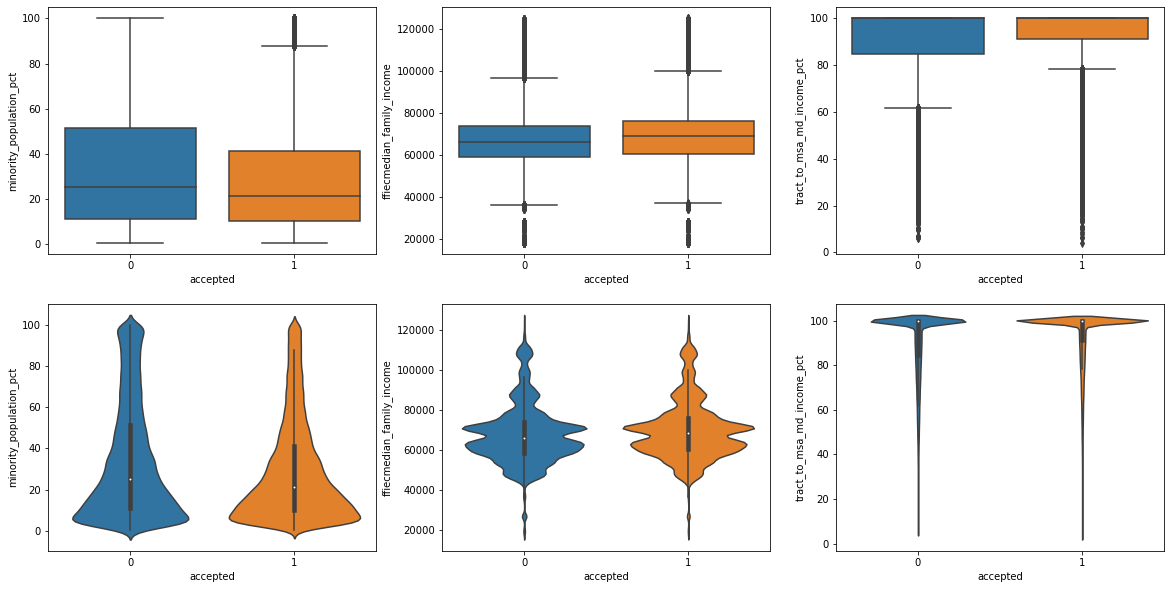

In [97]:
# Plotting some boxplots for the numerical variables
data_cat=train_data[var_numeric+var_numeric_pct+['accepted']]

n_plots=6

f, axes = plt.subplots(2, 3, sharey=False, figsize=(20,10))
sns.catplot(x="accepted", y="minority_population_pct", kind="box", data=data_cat, ax=axes[0,0])
sns.catplot(x="accepted", y="ffiecmedian_family_income", kind="box", data=data_cat, ax=axes[0,1])
sns.catplot(x="accepted", y="tract_to_msa_md_income_pct", kind="box", data=data_cat, ax=axes[0,2])

sns.catplot(x="accepted", y="minority_population_pct", kind="violin", data=data_cat, ax=axes[1,0])
sns.catplot(x="accepted", y="ffiecmedian_family_income", kind="violin", data=data_cat, ax=axes[1,1])
sns.catplot(x="accepted", y="tract_to_msa_md_income_pct", kind="violin", data=data_cat, ax=axes[1,2])

for i in range(2,2+n_plots):
    plt.close(i)
    
plt.show()

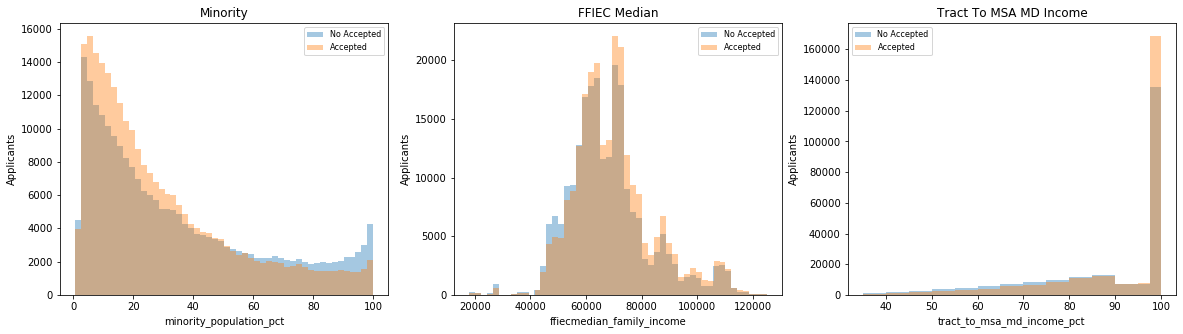

In [98]:
# Plotting some histograms for the categorical data
f, axes = plt.subplots(1, 3, figsize=(20,5))

data_cat=train_data[train_data['minority_population_pct'].notnull()][['minority_population_pct','accepted']]
df0 = data_cat[data_cat.accepted == 0]
df1 =data_cat[data_cat.accepted == 1]

sns.color_palette("hls", 8)

sns.distplot(df0['minority_population_pct'],  kde=False, label='No Accepted',ax=axes[0])
sns.distplot(df1['minority_population_pct'],  kde=False,label='Accepted',ax=axes[0])
axes[0].legend(prop={'size': 8})
axes[0].set_title('Minority')
axes[0].set_ylabel('Applicants')

data_cat=train_data[train_data['ffiecmedian_family_income'].notnull()][['ffiecmedian_family_income','accepted']]
df0 = data_cat[data_cat.accepted == 0]
df1 =data_cat[data_cat.accepted == 1]

sns.distplot(df0['ffiecmedian_family_income'],  kde=False, label='No Accepted',ax=axes[1])
sns.distplot(df1['ffiecmedian_family_income'],  kde=False,label='Accepted',ax=axes[1])
axes[1].legend(prop={'size': 8})
axes[1].set_title('FFIEC Median')
axes[1].set_ylabel('Applicants')

data_cat=train_data[train_data['tract_to_msa_md_income_pct'].notnull()][['tract_to_msa_md_income_pct','accepted']]
df0 = data_cat[data_cat.accepted == 0]
df1 =data_cat[data_cat.accepted == 1]

sns.distplot(df0['tract_to_msa_md_income_pct'],  kde=False, label='No Accepted',bins=[35,40,45,50,55,60,65,70,75,80,85,90, 92.5, 95, 97.5,100],ax=axes[2])
sns.distplot(df1['tract_to_msa_md_income_pct'],  kde=False,label='Accepted',bins=[35,40,45,50,55,60,65,70,75,80,85,90, 92.5, 95, 97.5,100], ax=axes[2])
axes[2].legend(prop={'size': 8}, loc=2)
axes[2].set_title('Tract To MSA MD Income')
axes[2].set_ylabel('Applicants')

plt.show()

- In locations where the percentage of minority population is low, their applicants tends to be accepted. When 60% of population is from a minority, the number of rejected applicants tends to get higher.
- As we detect previously, the lower the median of applicant income is the less likely to be accepted the loan is. Below 55,000$, the ratio of denied loans is bigger.

There are two features that present a normal distribution but we cannot appreciate any remarkable fact on them

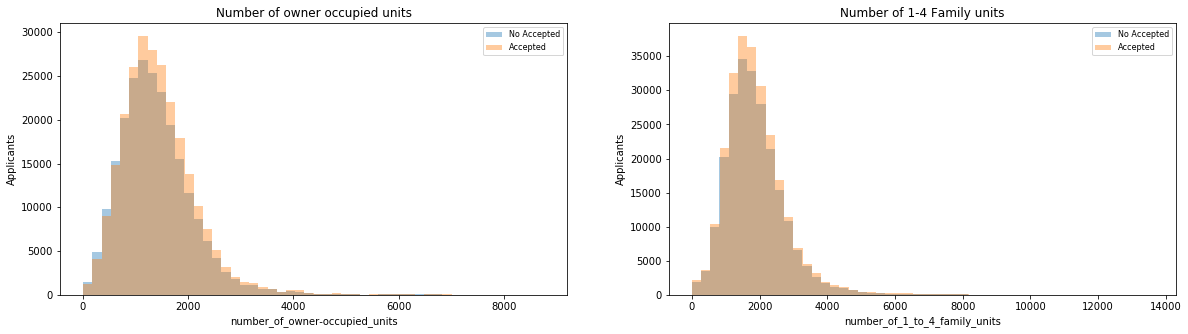

In [99]:
# Plotting some histograms for otrhers numerical variables
f, axes = plt.subplots(1, 2, figsize=(20,5))

data_cat=train_data[train_data['number_of_owner-occupied_units'].notnull()][['number_of_owner-occupied_units','accepted']]
df0 = data_cat[data_cat.accepted == 0]
df1 =data_cat[data_cat.accepted == 1]

sns.color_palette("hls", 8)

sns.distplot(df0['number_of_owner-occupied_units'],  kde=False, label='No Accepted',ax=axes[0])
sns.distplot(df1['number_of_owner-occupied_units'],  kde=False,label='Accepted',ax=axes[0])
axes[0].legend(prop={'size': 8})
axes[0].set_title('Number of owner occupied units')
axes[0].set_ylabel('Applicants')

data_cat=train_data[train_data['number_of_1_to_4_family_units'].notnull()][['number_of_1_to_4_family_units','accepted']]
df0 = data_cat[data_cat.accepted == 0]
df1 =data_cat[data_cat.accepted == 1]

sns.distplot(df0['number_of_1_to_4_family_units'],  kde=False, label='No Accepted',ax=axes[1])
sns.distplot(df1['number_of_1_to_4_family_units'],  kde=False,label='Accepted',ax=axes[1])
axes[1].legend(prop={'size': 8})
axes[1].set_title('Number of 1-4 Family units')
axes[1].set_ylabel('Applicants')

plt.show()

## Analyzing relation between numerical variables
At this moment we have some knowledge about the features and how the acceptance ratio is dependent on that. Next step, analyze how these features are related between them. So a scatter matrix is our tool to get that insight:

C:\Users\edumu\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
C:\Users\edumu\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


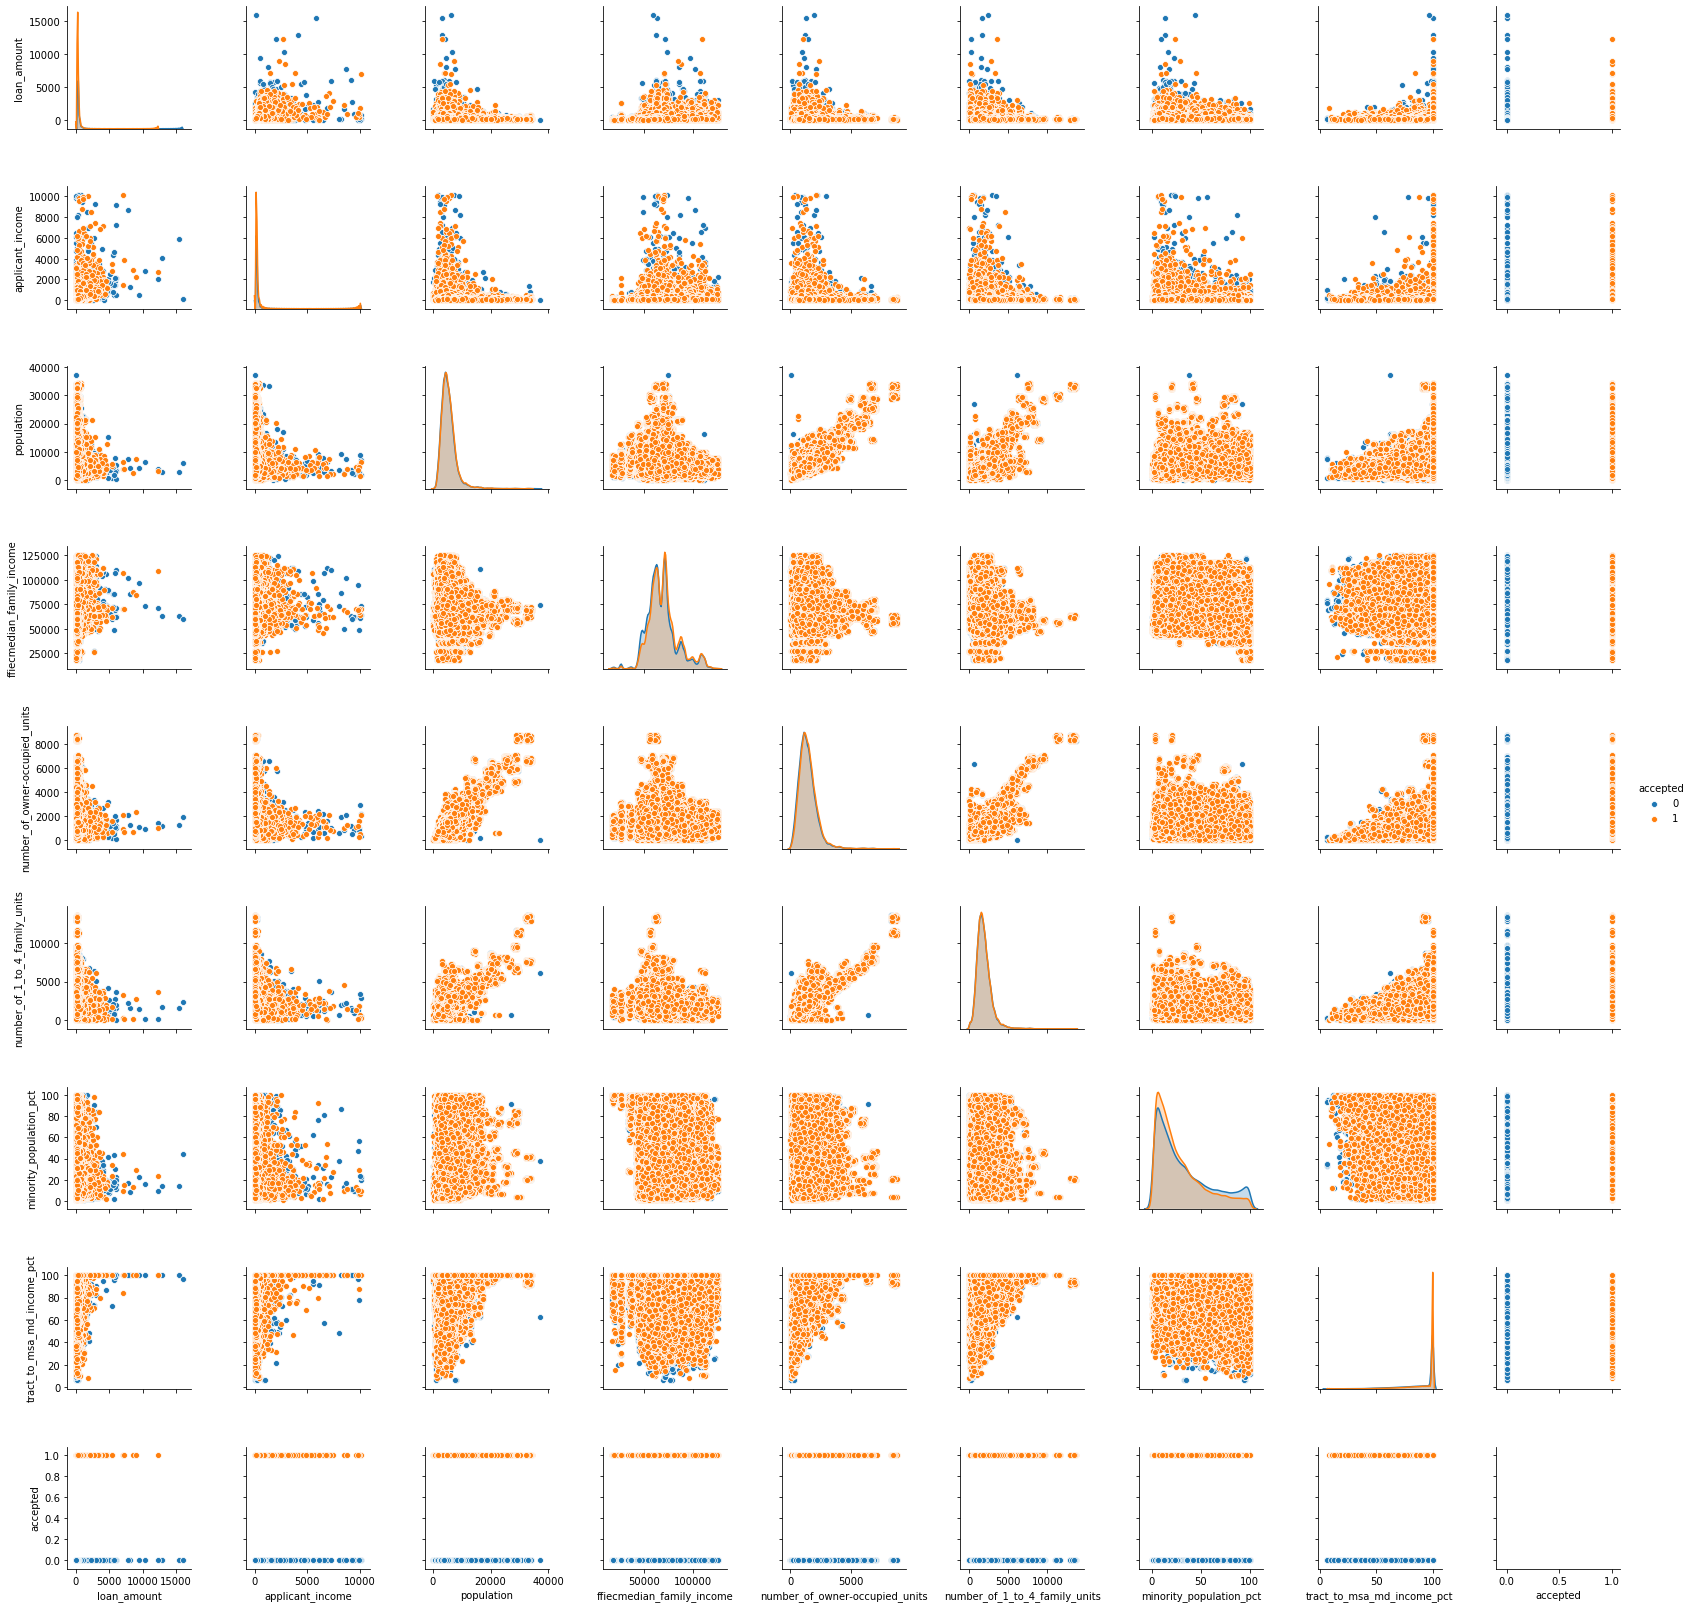

In [100]:
sns.pairplot(train_data_nona, hue='accepted')
plt.show()

- The relationship between the variables loan amount and applicant incomes with respect to each of the remaining variables allows us to identify accepted and not accepted loans. 
- There is a strong linear correlation between population, number of 1–4 family units and number of owner occupied units.

C:\Users\edumu\Anaconda3\lib\site-packages\seaborn\axisgrid.py:2065: UserWarning: The `size` parameter has been renamed to `height`; pleaes update your code.
  warnings.warn(msg, UserWarning)


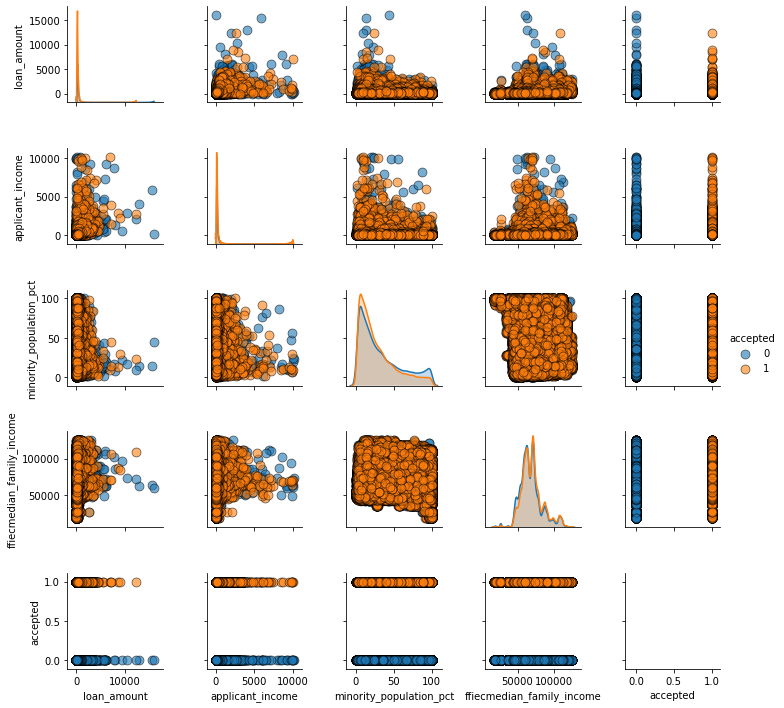

In [101]:
sns.pairplot(train_data_nona[['loan_amount','applicant_income','minority_population_pct','ffiecmedian_family_income','accepted']], hue='accepted',plot_kws = {'alpha': 0.6, 's': 80, 'edgecolor': 'k'},height=2)
plt.show()

### Analyzing Correlations between variables

In [102]:
# Correlation matrix for numeric features
train_data_nona.corr()

,loan_amount,applicant_income,population,ffiecmedian_family_income,number_of_owner-occupied_units,number_of_1_to_4_family_units,minority_population_pct,tract_to_msa_md_income_pct,accepted
loan_amount,1.000000,0.482570,0.007791,0.275633,0.000216,-0.056754,-0.008875,0.165119,0.098280
applicant_income,0.482570,1.000000,-0.006849,0.115143,0.004775,-0.019644,-0.053969,0.102784,0.070343
population,0.007791,-0.006849,1.000000,-0.012020,0.860475,0.815828,0.089370,0.147899,0.020018
ffiecmedian_family_income,0.275633,0.115143,-0.012020,1.000000,-0.020078,-0.148316,0.020134,-0.049267,0.071361
number_of_owner-occupied_units,0.000216,0.004775,0.860475,-0.020078,1.000000,0.886270,-0.210577,0.355338,0.039244
number_of_1_to_4_family_units,-0.056754,-0.019644,0.815828,-0.148316,0.886270,1.000000,-0.155884,0.205387,0.006950
minority_population_pct,-0.008875,-0.053969,0.089370,0.020134,-0.210577,-0.155884,1.000000,-0.438936,-0.096945
tract_to_msa_md_income_pct,0.165119,0.102784,0.147899,-0.049267,0.355338,0.205387,-0.438936,1.000000,0.097640
accepted,0.098280,0.070343,0.020018,0.071361,0.039244,0.006950,-0.096945,0.097640,1.000000


In [103]:
train_data[var_categoric+['accepted']].corr()

,loan_type,property_type,loan_purpose,occupancy,preapproval,state_code,county_code,msa_md,applicant_ethnicity,applicant_race,applicant_sex,lender,accepted
loan_type,1.000000,-0.065214,-0.121296,-0.158964,-0.133156,-0.047184,-0.016363,-0.024445,-0.050118,-0.016649,-0.072372,-0.027408,0.018589
property_type,-0.065214,1.000000,-0.114663,0.156139,0.046035,-0.017647,-0.007445,-0.076069,0.131192,0.063428,0.106785,-0.035769,-0.080603
loan_purpose,-0.121296,-0.114663,1.000000,0.002154,0.487352,0.118267,0.058151,0.072506,0.023305,0.021642,0.014322,0.051664,-0.131595
occupancy,-0.158964,0.156139,0.002154,1.000000,0.043719,0.011510,0.008150,-0.012271,0.159449,0.066717,0.132245,-0.001298,0.022043
preapproval,-0.133156,0.046035,0.487352,0.043719,1.000000,0.184239,0.158625,0.130471,0.016996,0.018578,0.019185,0.000559,0.017209
state_code,-0.047184,-0.017647,0.118267,0.011510,0.184239,1.000000,0.020158,0.146628,-0.001496,0.004311,-0.001860,0.020434,0.090534
county_code,-0.016363,-0.007445,0.058151,0.008150,0.158625,0.020158,1.000000,0.160215,0.005642,-0.003560,-0.000486,0.002781,0.052613
msa_md,-0.024445,-0.076069,0.072506,-0.012271,0.130471,0.146628,0.160215,1.000000,-0.011878,-0.025221,0.004989,0.013535,0.080288
applicant_ethnicity,-0.050118,0.131192,0.023305,0.159449,0.016996,-0.001496,0.005642,-0.011878,1.000000,0.280871,0.497732,0.009411,0.009777
applicant_race,-0.016649,0.063428,0.021642,0.066717,0.018578,0.004311,-0.003560,-0.025221,0.280871,1.000000,0.266636,0.005197,0.045361


C:\Users\edumu\Anaconda3\lib\site-packages\seaborn\axisgrid.py:1241: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(UserWarning(msg))


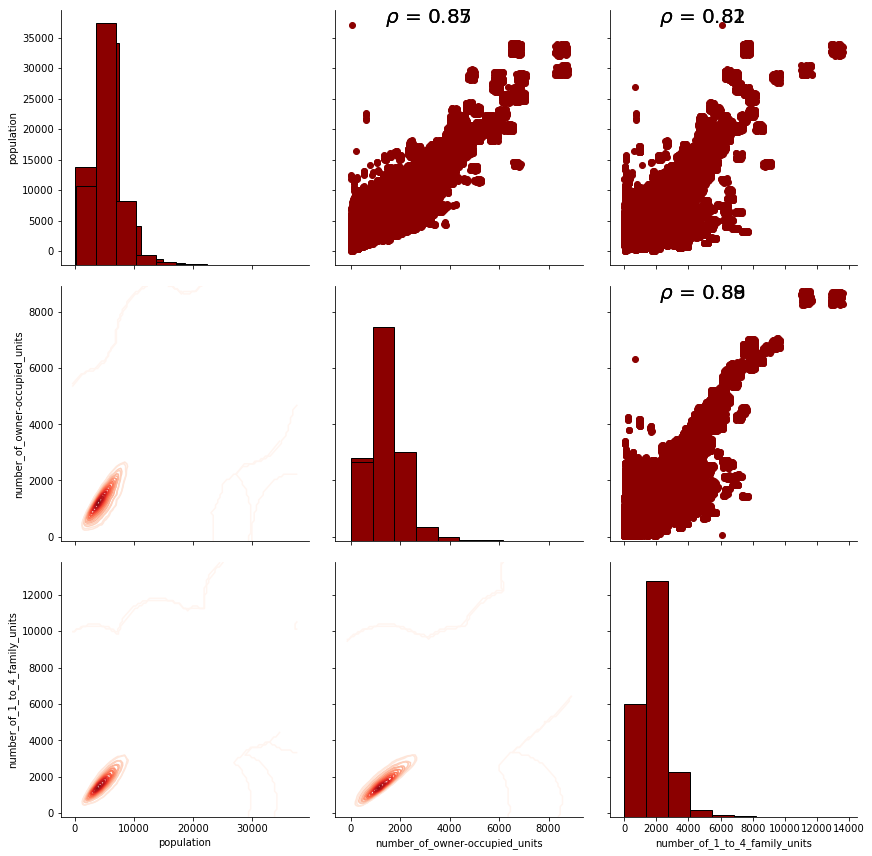

In [104]:
def corr(x, y, **kwargs):
    
    # Calculate the value
    coef = np.corrcoef(x, y)[0][1]
    # Make the label
    label = r'$\rho$ = ' + str(round(coef, 2))
    
    # Add the label to the plot
    ax = plt.gca()
    ax.annotate(label, xy = (0.2, 0.95), size = 20, xycoords = ax.transAxes)
    
# Create a pair grid instance
#grid = sns.PairGrid(data= train_data_nona[train_data_nona['accepted'] == 1],
grid = sns.PairGrid(data= train_data_nona,
                    vars = ['population', 'number_of_owner-occupied_units', 'number_of_1_to_4_family_units'], height = 4, hue='accepted')

# Map the plots to the locations
grid = grid.map_upper(plt.scatter, color = 'darkred')
grid = grid.map_upper(corr)
grid = grid.map_lower(sns.kdeplot, cmap = 'Reds')
grid = grid.map_diag(plt.hist, bins = 10, edgecolor =  'k', color = 'darkred')

- High values for loan amount and low applicant incomes are very likely to be rejected.
- There are no applications with a high loan amount in locations when % of minority population is very high, nor accepted or not accepted.
- In areas with high percentage of minorities, even applicants with relatively high incomes are rejected

The next step will be to design and build a predictive model based on the features just analyzed.